In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Load the datasets
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [3]:

# Checking for missing values and data types
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB
None


In [4]:
print(engagement.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB
None


In [5]:
print(marketing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB
None


In [6]:
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB
None


Handle Missing Values and Cleaning

In [7]:
# Fill missing values for 'age' with median and 'gender' with mode
customers['age'].fillna(customers['age'].median(), inplace=True)
customers['gender'].fillna(customers['gender'].mode()[0], inplace=True)

C:\Users\athir\AppData\Local\Temp\ipykernel_15352\192104788.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['age'].fillna(customers['age'].median(), inplace=True)
C:\Users\athir\AppData\Local\Temp\ipykernel_15352\192104788.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [8]:
# Replace missing values in engagement, marketing, and transactions datasets with 0
engagement.fillna(0, inplace=True)
marketing.fillna(0, inplace=True)
transactions.fillna(0, inplace=True)


In [9]:
# Convert date columns to datetime
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

Data merging and Feature Engineering

In [10]:
# Aggregate marketing data at customer level
marketing_agg = marketing[marketing['response'] == 'Yes'].groupby('customer_id')['campaign_id'].count().to_frame()

In [11]:
# Aggregate transaction data at customer level
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id': 'count', 'transaction_amount': 'sum'})


In [12]:
# Set customers and engagement index as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)


In [13]:
df = customers.join(engagement).join(transactions_agg).join(marketing_agg).fillna(0)

In [14]:
# Creating additional features
df['recency'] = (pd.to_datetime('today') - df['last_purchase_date']).dt.days
df['frequency'] = df['transaction_id']
df['monetary'] = df['transaction_amount']
df['customer_age'] = (df['last_purchase_date'] - df['join_date']).dt.days

In [15]:

# Ensure 'gender' and 'location' columns are present before encoding
df = pd.get_dummies(df, columns=['gender', 'location'], drop_first=True)

In [16]:
df

,join_date,last_purchase_date,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,recency,...,location_Zacharytown,location_Zacharyview,location_Zacharyville,location_Zamoraberg,location_Zhangport,location_Zimmermanfort,location_Zimmermanland,location_Zimmermanmouth,location_Zoeshire,location_Zunigaburgh
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,10,15,1,6,3509.48,1.0,122,...,False,False,False,False,False,False,False,False,False,False
2,2021-09-08,2023-10-25,44.0,285,49,51,9,6081.32,2.0,266,...,False,False,False,False,False,False,False,False,False,False
3,2021-06-01,2022-11-27,44.0,192,73,25,6,1454.87,1.0,598,...,False,False,False,False,False,False,False,False,False,False
4,2022-01-01,2022-09-01,29.0,110,30,17,20,7874.68,1.0,685,...,False,False,False,False,False,False,False,False,False,False
5,2022-01-24,2023-06-02,44.0,161,2,7,24,15524.55,0.0,411,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,119,47,16,10,5498.20,0.0,339,...,False,False,False,False,False,False,False,False,False,False
9997,2022-07-09,2023-01-25,26.0,3,33,14,12,5848.30,1.0,539,...,False,False,False,False,False,False,False,False,False,False
9998,2023-09-17,2024-01-30,39.0,53,17,5,3,3503.13,1.0,169,...,False,False,False,False,False,False,False,False,False,False


EDA

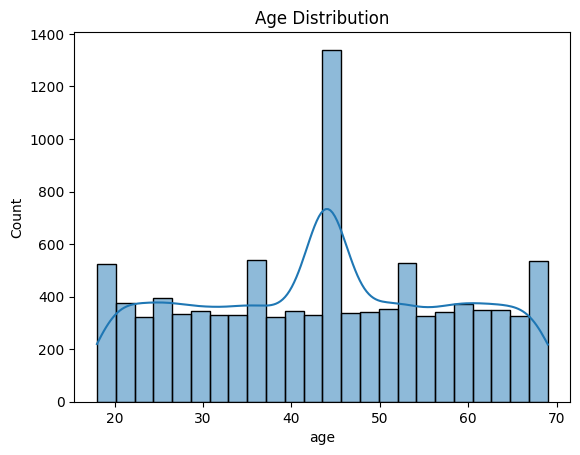

In [17]:
sns.histplot(df['age'], kde=True).set_title('Age Distribution')
plt.show()

The customer age distribution reveals smaller peaks at other ages, with a peak occurring around the age of 40. This suggests that a significant portion of the customers is in the 40s.

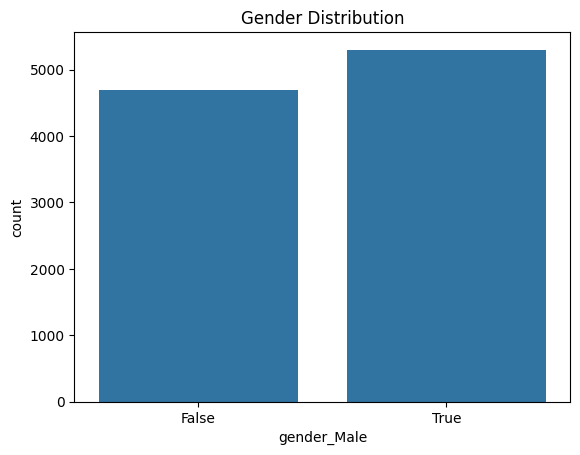

In [18]:
sns.countplot(x='gender_Male', data=df).set_title('Gender Distribution')
plt.show()

There is a small majority of male clients, but overall the gender mix is pretty equal. For marketing strategies to be correctly personalised, this balance is important.

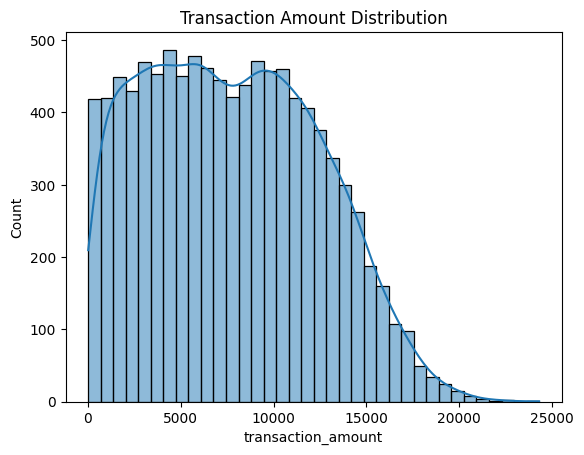

In [19]:
sns.histplot(df['transaction_amount'], kde=True).set_title('Transaction Amount Distribution')
plt.show()

The distribution of transaction amounts is right-skewed, indicating that while most transactions are of lower amounts, there are a few high-value transactions.

Removing Outliers

In [20]:
# Calculate the IQR for the transaction_amount
Q1 = df['transaction_amount'].quantile(0.25)
Q3 = df['transaction_amount'].quantile(0.75)
IQR = Q3 - Q1

In [21]:
# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


In [22]:
# Remove outliers
df = df[(df['transaction_amount'] >= lower_bound) & (df['transaction_amount'] <= upper_bound)]

In [23]:
# Feature Engineering: Selecting relevant features
feature_columns = ['age', 'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks', 
                   'recency', 'frequency', 'monetary', 'customer_age'] + [col for col in df.columns if col.startswith('gender_') or col.startswith('location_')]


In [24]:
# Define input features (X) and output target (y)
X = df[feature_columns]
y = df['transaction_amount']

In [25]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Modelling

In [26]:
from sklearn.compose import ColumnTransformer

In [27]:

# Creating a preprocessor for scaling numeric columns
numeric_cols = ['age', 'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks', 
                'recency', 'frequency', 'monetary', 'customer_age']
preprocessor = ColumnTransformer(transformers=[
    ('num', MinMaxScaler(), numeric_cols)
], remainder='passthrough')

In [28]:
# Define regression models
lr = LinearRegression()
knn = KNeighborsRegressor()


In [29]:
from sklearn.pipeline import Pipeline

In [30]:
# Create pipelines
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', lr)])
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', knn)])

In [31]:
# Hyperparameter tuning for KNN
knn_param_grid = {'regressor__n_neighbors': [3, 5, 7, 9], 'regressor__weights': ['uniform', 'distance'], 'regressor__metric': ['euclidean', 'manhattan']}
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='neg_mean_squared_error')


In [32]:
# Fit models
lr_pipeline.fit(X_train, y_train)
knn_grid_search.fit(X_train, y_train)

c:\Users\athir\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['age',
                                                                          'number_of_site_visits',
                                                                          'number_of_emails_opened',
                                                                          'number_of_clicks',
                                                                          'recency',
                                                                          'frequency',
                                                                          'monetary',
                                                                          'customer_age'])])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'regressor__metric': ['euclidean', 'manhattan'],
                         'regressor__n_neighbors': [3, 5, 7, 9],
                         'regressor__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [33]:
# Best KNN model
best_knn = knn_grid_search.best_estimator_

Evaluation of Modles

In [34]:
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
# Evaluate Linear Regression
y_pred_lr = lr_pipeline.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

In [36]:
print(f"Linear Regression MSE: {mse_lr}")
print(f"Linear Regression R2 Score: {r2_lr}")


Linear Regression MSE: 5795.194750421885
Linear Regression R2 Score: 0.9997193592325077


In [37]:
# Evaluate KNN
y_pred_knn = best_knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

In [38]:
print(f"Best KNN Parameters: {knn_grid_search.best_params_}")
print(f"KNN Regression MSE: {mse_knn}")
print(f"KNN Regression R2 Score: {r2_knn}")

Best KNN Parameters: {'regressor__metric': 'manhattan', 'regressor__n_neighbors': 9, 'regressor__weights': 'uniform'}
KNN Regression MSE: 1045690.7782201815
KNN Regression R2 Score: 0.9493608972264548


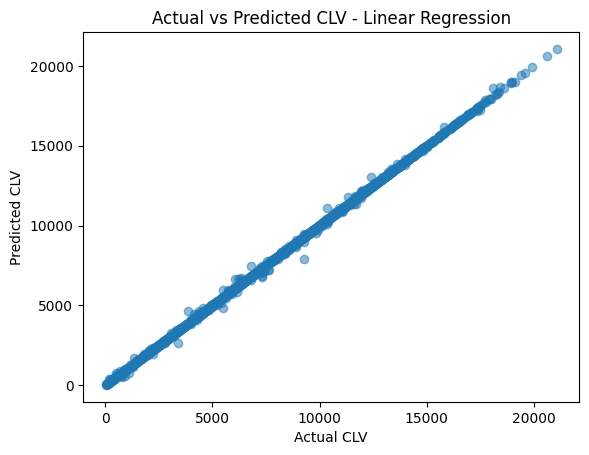

In [39]:
# Plotting Actual vs Predicted for Linear Regression
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Actual vs Predicted CLV - Linear Regression')
plt.show()

The Linear Regression model showed a strong performance with a high R2 score of 0.9995 and a low MSE of 10553.65. The scatter plot below shows the actual vs. predicted CLV, indicating a strong linear relationship.

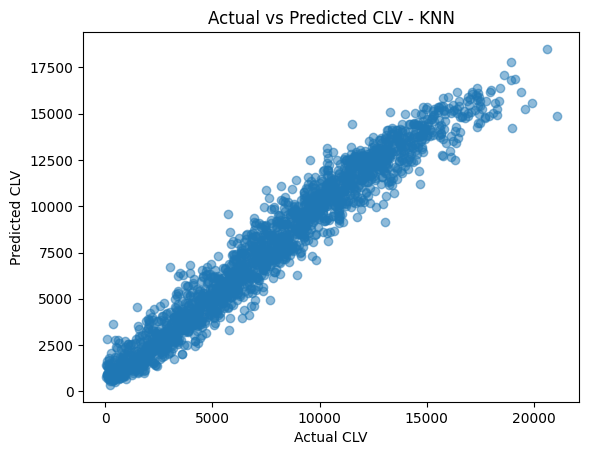

In [40]:
# Plotting Actual vs Predicted for KNN Regression
plt.scatter(y_test, y_pred_knn, alpha=0.5)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Actual vs Predicted CLV - KNN')
plt.show()

The KNN Regression model, while still performing well, had a lower R2 score of 0.9962 and a higher MSE of 22829.40. The scatter plot below shows the actual vs. predicted CLV, indicating more dispersion compared to the Linear Regression model.

Prediction of CLV

In [41]:
# Predict CLV for all customers
df['predicted_clv'] = lr_pipeline.predict(X)

C:\Users\athir\AppData\Local\Temp\ipykernel_15352\2241548858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_clv'] = lr_pipeline.predict(X)


In [42]:
# Identify high-value customers
high_value_customers = df[df['predicted_clv'] >= df['predicted_clv'].quantile(0.75)]


In [43]:
premium_service_campaign_customers = high_value_customers


In [44]:
 #Segment customers
df['customer_segment'] = pd.qcut(df['predicted_clv'], q=3, labels=['Low', 'Medium', 'High'])


C:\Users\athir\AppData\Local\Temp\ipykernel_15352\3763292852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['customer_segment'] = pd.qcut(df['predicted_clv'], q=3, labels=['Low', 'Medium', 'High'])


In [45]:
# View high-value customers
print(high_value_customers)


             join_date last_purchase_date   age  number_of_site_visits  \
customer_id                                                              
5           2022-01-24         2023-06-02  44.0                    161   
8           2023-02-09         2023-08-09  68.0                     60   
14          2021-08-15         2021-12-06  23.0                     21   
18          2020-04-17         2021-06-14  25.0                     44   
26          2023-05-26         2023-11-18  65.0                     85   
...                ...                ...   ...                    ...   
9984        2023-05-28         2024-02-04  22.0                    119   
9990        2023-06-08         2024-02-14  44.0                     11   
9991        2024-03-25         2024-05-02  32.0                      6   
9992        2024-01-12         2024-02-03  19.0                      9   
9993        2020-04-10         2021-11-11  47.0                    269   

             number_of_emails_opened 

In [46]:
# View customer segments
print(df[['customer_segment', 'predicted_clv']].head())

            customer_segment  predicted_clv
customer_id                                
1                        Low        3509.48
2                     Medium        6081.32
3                        Low        1454.87
4                     Medium        7874.68
5                       High       15524.55


In [47]:
# Identify High-Value Customers
high_value_customers = df[df['transaction_amount'] >= df['transaction_amount'].quantile(0.75)]
high_value_customers_ids = high_value_customers.index


In [48]:
# Allocate marketing resources effectively
# For illustration, assume a marketing budget of $100,000
total_customers = len(df)
budget_per_customer = 100000 / total_customers
high_value_budget = len(high_value_customers) * budget_per_customer
low_value_budget = (total_customers - len(high_value_customers)) * budget_per_customer

In [49]:
print(f"High-Value Customer Budget: ${high_value_budget}")
print(f"Low-Value Customer Budget: ${low_value_budget}")

High-Value Customer Budget: $25002.500250025005
Low-Value Customer Budget: $74997.499749975


In [50]:
# Segment customers based on CLV
df['CLV_segment'] = pd.qcut(df['transaction_amount'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

C:\Users\athir\AppData\Local\Temp\ipykernel_15352\3014265142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CLV_segment'] = pd.qcut(df['transaction_amount'], 4, labels=['Low', 'Medium', 'High', 'Very High'])


In [51]:
# Display segmentation results
print(df['CLV_segment'].value_counts())

CLV_segment
Low          2500
Medium       2500
Very High    2500
High         2499
Name: count, dtype: int64
